## Description:

    Diversity estimates on samples merged by PlantxFert

    Work in progress, using relative abundance errors is throwing an error in alpha diversity metric.
    

In [1]:

%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(lme4)
library(lmerTest)
library(MuMIn)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: iterators

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:gridExtra’:

    combine


  warnings.warn(x, RRuntimeWarning)
/opt/anacon

# Loading phyloseq object

In [3]:
%%R
F = file.path('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds')
physeq.Full = readRDS(F)

#rarefy to standard depth
set.seed(45)
phy.r = rarefy_even_depth(physeq.Full) %>%
        subset_samples(SeedTreatment != "Untreated" & TimePoint != "T0" & Plant != "Bare")


phy.r

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: ...

  warnings.warn(x, RRuntimeWarning)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [4]:
%%R
# add interaction of genotype and sampling date term for merge
sd = sample_data(phy.r)
sd = mutate(sd, TxGxF = paste(TimePoint, R_Year, Fert, sep = "_"))
rownames(sd) = sd$X.sampleID
sample_data(phy.r) = sd


In [5]:
%%R
# save TxG, R_Year and Sampling date lookup table

Y.df = sd %>%
    select(TxGxF, R_Year, TimePoint, Fert) %>%
    unique
colnames(Y.df) = c("Sample", "R_Year", "TimePoint", "Fert")
head(Y.df)


                     Sample R_Year TimePoint Fert
ERA-T2_3-1d_85   T2_2001_85   2001        T2   85
ERA-T1_3-5c_170 T1_1939_170   1939        T1  170
ERA-T1_1-4b_0     T1_2001_0   2001        T1    0
ERA-T1_1-4a_170 T1_1953_170   1953        T1  170
ERA-T3_1-3c_170 T3_1971_170   1971        T3  170
ERA-T1_4-4a_170 T1_1984_170   1984        T1  170


In [6]:
%%R
dim(Y.df)

[1] 48  4


In [7]:
%%R
m.phy = merge_samples(phy.r, "TxGxF")  %>%

    transform_sample_counts(function(x) x/sum(x))
        
m.phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [8]:
%%R
sample_sums(m.phy) %>% min

[1] 1


### set ggplot theme

In [9]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }


In [10]:
%%R
sample_data(m.phy)$TxGxF = rownames(sample_data(m.phy))

In [11]:
%%R
# add planted variable

sd = sample_data(m.phy) %>%
    select(-R_Year, -TimePoint, -Fert)
sd = left_join(sd, Y.df, by = c("TxGxF" = "Sample"))
head(sd)
# sd = mutate(sd, Planted = ifelse(Genotype == "Bare" | TimePoint == "T0", "Bare", "Rhizosphere"))
# rownames(sd) = sd$X.sampleID
# sd %>% head
# sample_data(phy.r) = sd

  X.sampleID TubeID ExtractionPlate PooledDNAPlate Sample.Well.ID PrimerPlate
1      36.25  37.50               3           1.50          51.50        1.50
2      37.25  37.25               3           1.50          37.50        1.50
3      38.25  37.00               3           2.25          18.00        2.25
4      37.75  38.75               3           1.50          25.25        1.50
5      38.75  39.25               3           1.50          53.50        1.50
6      39.75  38.25               3           1.50          51.75        1.50
  Primer.Number Primer.Well.ID  X primerFwdLoc primerRevLoc fwd_barcode
1         48.50          51.50 NA         8.50        15.50        8.50
2         37.50          37.50 NA         7.50        13.50       11.75
3         36.25          19.75 NA        12.25        18.00        5.00
4         50.50          25.25 NA         6.50        13.25        8.00
5         44.75          53.50 NA         8.75        15.00        9.25
6         48.75       

# Alpha Diversity

In [12]:
# %%R -w 800 -h 350
# alpha_meas = c("Observed", "Chao1", "Shannon", "Simpson")
# (p <- plot_richness(m.phy, "Planted", measures=alpha_meas))

# Alpha diversity variation among plants

In [32]:
%%R

#sample_data(phy.p)$Fert = as.factor(sample_data(phy.p))
alpha_meas = c("Observed", "Chao1", "Shannon", "Simpson")
p = plot_richness(phy.p, measures=alpha_meas)

p$data$Fert = as.factor(p$data$Fert)


Error in otu_table(physeq) : object 'phy.p' not found


* Center year for interpretation

In [14]:
%%R
p$data$R_Year.c = p$data$R_Year - 1935


Error in withVisible({ : object 'p' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in withVisible({ : object 'p' not found

  warnings.warn(x, RRuntimeWarning)


## alpha  T1

In [15]:
%%R
p.T1 = p$data %>% filter(TimePoint == "T1") 
ggplot(p.T1, aes(x = as.factor(R_Year), y = value, color = as.factor(Fert))) +
geom_boxplot() +
geom_point()+
facet_wrap(~variable, ncol = 2, scales = "free_y")


Error in eval(expr, envir, enclos) : object 'p' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in eval(expr, envir, enclos) : object 'p' not found

  warnings.warn(x, RRuntimeWarning)


In [16]:
%%R
#test library effects on microbial diversity
tmp = p.T1 %>% filter(variable == "Chao1")

fit1 = lmer(value~ Fert*R_Year.c + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print
coef(fit1) %>% print
confint(fit1) %>% print


Error in eval(expr, envir, enclos) : object 'p.T1' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in eval(expr, envir, enclos) : object 'p.T1' not found

  warnings.warn(x, RRuntimeWarning)


In [17]:
%%R
#test library effects on microbial diversity
tmp = p.T1 %>% filter(variable == "Shannon")

fit1 = lmer(value~ Fert*R_Year.c + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print
coef(fit1) %>% print
confint(fit1) %>% print


Error in eval(expr, envir, enclos) : object 'p.T1' not found


## alpha at T2

In [18]:
%%R
p.T2 = p$data %>% filter(TimePoint == "T2") 
ggplot(p.T2, aes(x = as.factor(R_Year), y = value)) +
geom_boxplot() +
geom_point()+
facet_wrap(~variable, ncol = 2, scales = "free_y")


Error in eval(expr, envir, enclos) : object 'p' not found


In [19]:
%%R
#test library effects on microbial diversity
tmp = p.T2 %>% filter(variable == "Chao1")

fit1 = lmer(value~ R_Year.c + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print
coef(fit1) %>% print
confint(fit1) %>% print


Error in eval(expr, envir, enclos) : object 'p.T2' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in eval(expr, envir, enclos) : object 'p.T2' not found

  warnings.warn(x, RRuntimeWarning)


* There was an increase in estimated richness (Chao1) with year of release, but overall model explained low portion of variance

In [20]:
%%R
#test library effects on microbial diversity
tmp = p.T2 %>% filter(variable == "Shannon")

fit1 = lmer(value~ R_Year.c + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print
coef(fit1) %>% print
confint(fit1) %>% print


Error in eval(expr, envir, enclos) : object 'p.T2' not found


In [21]:
%%R
p1 = ggplot(tmp, aes(x = kgdw_ha, y = value, color = as.factor(ERA)))+
geom_point() +
ylab("Chao1") 

p2 = ggplot(tmp, aes(x = as.factor(ERA), y = value))+
geom_point() +
geom_boxplot() +
ylab("Chao1")

grid.arrange(p1, p2, ncol = 1)



Error in ggplot(tmp, aes(x = kgdw_ha, y = value, color = as.factor(ERA))) : 
  object 'tmp' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in ggplot(tmp, aes(x = kgdw_ha, y = value, color = as.factor(ERA))) : 
  object 'tmp' not found

  warnings.warn(x, RRuntimeWarning)


## alpha at T3

In [22]:
%%R
p.T3 = p$data %>% filter(TimePoint == "T3") 
ggplot(p.T3, aes(x = as.factor(R_Year), y = value, color = as.factor(Fert))) +
geom_boxplot() +
geom_point()+
facet_wrap(~variable, ncol = 2, scales = "free_y")


Error in eval(expr, envir, enclos) : object 'p' not found


In [23]:
%%R
#test library effects on microbial diversity
tmp = p.T3 %>% filter(variable == "Chao1")

fit1 = lmer(value~ Fert*R_Year.c + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print
coef(fit1) %>% print
confint(fit1) %>% print


Error in eval(expr, envir, enclos) : object 'p.T3' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in eval(expr, envir, enclos) : object 'p.T3' not found

  warnings.warn(x, RRuntimeWarning)


In [24]:
%%R
#test library effects on microbial diversity
tmp = p.T3 %>% filter(variable == "Shannon")

fit1 = lmer(value~ Fert*R_Year.c + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print
coef(fit1) %>% print
confint(fit1) %>% print


Error in eval(expr, envir, enclos) : object 'p.T3' not found


* R_Year seems to havea  significant effect on observed and estimated richness, but not diversity measures
* Should check other timepoints and fert effects next
* Check to see if richness or eveness is correlated with growth characteristic


# Graph alpha patterns

In [25]:
%%R
head(p$data)


Error in head(p$data) : object 'p' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in head(p$data) : object 'p' not found

  warnings.warn(x, RRuntimeWarning)


In [26]:
%%R
Time = c("T1", "T2", "T3")
Stage = c("V6", "R1", "R3")
dS = cbind(Time, Stage) %>% as.data.frame()
df = p$data %>%
    group_by(Genotype, Fert, R_Year, TimePoint, variable) %>%
    summarize(mValue = mean(value),
             seValue = sd(value)/sqrt(length(value)))  
df = left_join(df, dS, by = c("TimePoint" = "Time"))
df$Stage = factor(df$Stage, levels = c("V6", "R1", "R3"))
head(df)


Error in eval(expr, envir, enclos) : object 'p' not found


In [27]:
%%R

tmp = df %>% filter(variable == "Chao1") 
pC = ggplot(tmp, aes(x = R_Year, y = mValue, color = as.factor(Fert))) +
geom_point(position=position_dodge(width=0.9))+
geom_errorbar(aes(ymin = mValue - seValue, ymax = mValue + seValue), width = 2, position=position_dodge(width=0.9))+
theme_pub() +
facet_wrap(~Stage, ncol = 1)+
xlab("Year of release") +
ylab("Chao1 estimated richness") +
theme(legend.position = "bottom")
pC


Error in UseMethod("filter_") : 
  no applicable method for 'filter_' applied to an object of class "function"


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in UseMethod("filter_") : 
  no applicable method for 'filter_' applied to an object of class "function"

  warnings.warn(x, RRuntimeWarning)


In [28]:
%%R

 tmp = df %>% filter(variable %in% c("Chao1", "Shannon")) 
pS = ggplot(tmp, aes(x = R_Year, y = mValue, color = as.factor(Fert))) +
geom_point(position=position_dodge(width=4))+
geom_errorbar(aes(ymin = mValue - seValue, ymax = mValue + seValue), position=position_dodge(width=4))+
theme_pub() +
facet_grid(variable~Stage, scales = "free_y")+
xlab("Year of release") +
ylab("")+
theme(legend.position = "bottom")
pS


Error in UseMethod("filter_") : 
  no applicable method for 'filter_' applied to an object of class "function"


# alpha diversity in seed treatments

In [29]:
%%R
phy.st = subset_samples(phy.r, Genotype %in% c("322", "3475", "34N42", "354") & TimePoint == "T2")
phy.st

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 16 samples ]
sample_data() Sample Data:       [ 16 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [30]:
%%R
alpha_meas = c("Observed", "Chao1", "Shannon", "Simpson")
p = plot_richness(phy.st, measures=alpha_meas)

p$data$Fert = as.factor(p$data$Fert)
p$data$R_Year.c = p$data$R_Year - 1935

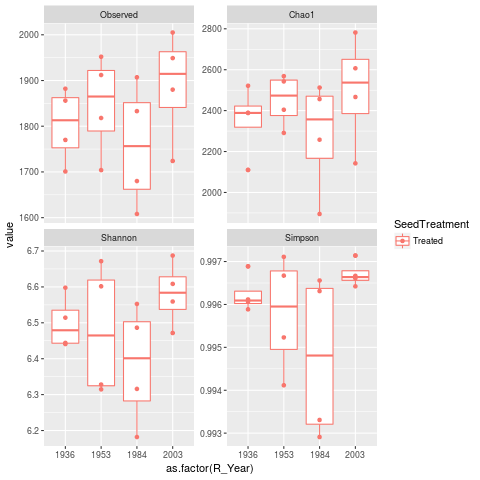

In [31]:
%%R

ggplot(p$data, aes(x = as.factor(R_Year), y = value, color = SeedTreatment)) +
geom_boxplot() +
geom_point()+
facet_wrap(~variable, ncol = 2, scales = "free_y")

In [183]:
%%R
#test library effects on microbial diversity
tmp = p$data %>% filter(variable == "Chao1")

fit1 = lmer(value~ Genotype*SeedTreatment + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print


Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                       Sum Sq Mean Sq NumDF DenDF F.value  Pr(>F)  
Genotype               196520   65507     3    21 2.94645 0.05643 .
SeedTreatment            2126    2126     1    21 0.09563 0.76019  
Genotype:SeedTreatment  48453   16151     3    21 0.72646 0.54756  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
      R2m       R2c 
0.1386885 0.6131717 


In [186]:
%%R
#test library effects on microbial diversity
tmp = p$data %>% filter(variable == "Chao1")

fit1 = lmer(value~ R_Year*SeedTreatment + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                     Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
R_Year                35869   35869     1    25  1.4012 0.2477
SeedTreatment         36261   36261     1    25  1.4165 0.2452
R_Year:SeedTreatment  36035   36035     1    25  1.4077 0.2466
       R2m        R2c 
0.04354907 0.53318643 


* among the plants sampled in treated and untreated plots, there was no effect of seed treatment on Chao1 and no interaction between year of release and chao1
* There was also no interaction between genotype and seed treatment.  
* The positive trend was less evident in the untreated batch, 

In [187]:
%%R
#test library effects on microbial diversity
tmp = p$data %>% filter(variable == "Shannon")

fit1 = lmer(value~ Genotype*SeedTreatment + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print


Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                         Sum Sq  Mean Sq NumDF DenDF F.value Pr(>F)
Genotype               0.028907 0.009636     3    21  0.5125 0.6781
SeedTreatment          0.046196 0.046196     1    21  2.4570 0.1319
Genotype:SeedTreatment 0.126113 0.042038     3    21  2.2359 0.1139
      R2m       R2c 
0.2269201 0.3426992 


In [188]:
%%R
#test library effects on microbial diversity
tmp = p$data %>% filter(variable == "Shannon")

fit1 = lmer(value~ R_Year.c*SeedTreatment + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                          Sum Sq   Mean Sq NumDF DenDF F.value Pr(>F)
R_Year.c               0.0092985 0.0092985     1    25  0.4554 0.5060
SeedTreatment          0.0000450 0.0000450     1    25  0.0022 0.9629
R_Year.c:SeedTreatment 0.0300965 0.0300965     1    25  1.4740 0.2361
      R2m       R2c 
0.1050251 0.2233130 


*Similarly there was not an effect of seed treatment on Shannon's H and no interaction between seed treatment and year of release, or seed treatment and genotype.

## Graph seed treatments

In [197]:
%%R
head(p$data)

Source: local data frame [6 x 8]
Groups: Genotype, Fert, R_Year, TimePoint [3]

  Genotype   Fert R_Year TimePoint variable      mValue     seValue Stage
    <fctr> <fctr>  <int>    <fctr>   <fctr>       <dbl>       <dbl> <chr>
1      322     85   1936        T2    Chao1 2299.601108 72.67746406    R1
2      322     85   1936        T2  Shannon    6.496529  0.03628327    R1
3     3475     85   1984        T2    Chao1 2333.094263 69.86645130    R1
4     3475     85   1984        T2  Shannon    6.416202  0.05499397    R1
5    34N42     85   2003        T2    Chao1 2469.333361 86.13739419    R1
6    34N42     85   2003        T2  Shannon    6.449385  0.07037531    R1


In [200]:
%%R

df = p$data %>%
    group_by(Genotype, Fert, R_Year, TimePoint, SeedTreatment, variable) %>%
    summarize(mValue = mean(value),
             seValue = sd(value)/sqrt(length(value)))  %>%
    mutate(Stage = "R1")


head(df)

Source: local data frame [6 x 9]
Groups: Genotype, Fert, R_Year, TimePoint, SeedTreatment [2]

  Genotype   Fert R_Year TimePoint SeedTreatment variable       mValue
    <fctr> <fctr>  <int>    <fctr>        <fctr>   <fctr>        <dbl>
1      322     85   1936        T2       Treated Observed 1788.0000000
2      322     85   1936        T2       Treated    Chao1 2270.5319714
3      322     85   1936        T2       Treated  Shannon    6.5007564
4      322     85   1936        T2       Treated  Simpson    0.9962788
5      322     85   1936        T2     Untreated Observed 1803.7500000
6      322     85   1936        T2     Untreated    Chao1 2328.6702437
# ... with 2 more variables: seValue <dbl>, Stage <chr>


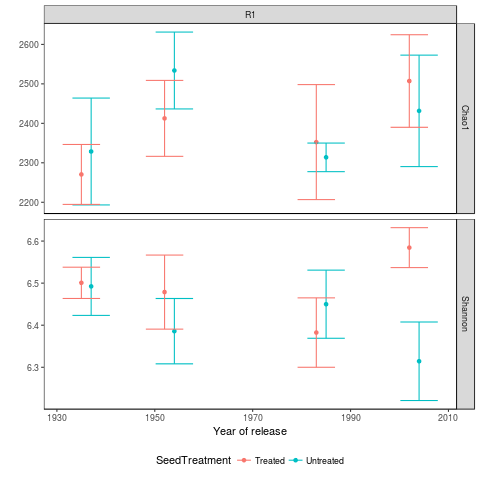

In [201]:
%%R
## Graph seed treatments

tmp = df %>% filter(variable %in% c("Chao1", "Shannon")) 
p = ggplot(tmp, aes(x = R_Year, y = mValue, color = SeedTreatment)) +
geom_point(position=position_dodge(width=4))+
geom_errorbar(aes(ymin = mValue - seValue, ymax = mValue + seValue), position=position_dodge(width=4))+
theme_pub() +
facet_grid(variable~Stage, scales = "free_y")+
xlab("Year of release") +
ylab("")+
theme(legend.position = "bottom")
p


In [ ]:

tmp = df %>% filter(variable %in% c("Chao1", "Shannon")) 
pS = ggplot(tmp, aes(x = R_Year, y = mValue, color = as.factor(Fert))) +
geom_point(position=position_dodge(width=4))+
geom_errorbar(aes(ymin = mValue - seValue, ymax = mValue + seValue), position=position_dodge(width=4))+
theme_pub() +
facet_grid(variable~Stage, scales = "free_y")+
xlab("Year of release") +
ylab("")+
theme(legend.position = "bottom")
pS